# Membuat Model Klasifikasi Rambu Lalu Lintas

Proyek kali ini, kita akan membuat model machine learning terkait dengan penerapan computer vision pada self-driving cars. Kita akan membuat model klasifikasi gambar dengan data berupa rambu-rambu lalu lintas.

# Loading Data
Proses loading data training dan testing.

Import library yang akan digunakan.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Kemudian, lakukan mount drive dengan code berikut:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Melakukan load data

In [3]:
## Load the data
training_file = "/content/drive/MyDrive/German Traffic Sign/train.p"
testing_file = "/content/drive/MyDrive/German Traffic Sign/test.p"   
 
# Open and load the training file 
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
 
# Open and load the training file
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
print("Data loaded")

Data loaded


Jika prosesnya berjalan, akan muncul output: Data loaded. 



---



# Eksplorasi Data

Tahapan eksplorasi data yang pertama adalah membaca file signnames.csv. File ini berisi id dan nama kelas dataset traffic sign.

In [4]:
## let's create a pandas dataframe to load csv
## The content of csv file is ClassId and the SignName
 
sign_name_df = pd.read_csv('/content/drive/MyDrive/German Traffic Sign/signnames.csv')
SIGN_NAMES = sign_name_df.SignName.values
sign_name_df.set_index('ClassId', inplace=True)
sign_name_df.head(10)

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


Selanjutnya, kita akan mendefinisikan fitur dan label pada data pickle yang telah di-load, lalu mengonversi lists menjadi numpy array. Kita akan melakukan ini pada data Training dan data Testing.

In [5]:
# Define features and labels for training data 
X, y = train['features'], train['labels']
 
# Converting lists into numpy arrays
data = np.array(X)
labels = np.array(y)
print(data.shape, labels.shape)
 
# Define the features and labels for testing data
X_test, y_test = test['features'], test['labels']
 
# Converting lists into numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(34799, 32, 32, 3) (34799,)
(12630, 32, 32, 3) (12630,)


Tahapan selanjutnya adalah melakukan split pada data training sehingga menjadi training dan validasi. Jadi, nanti kita akan memiliki tiga data, antara lain:

* Data training
* Data validasi
* Data testing

Seperti biasa, untuk membagi dataset, kita akan menggunakan fungsi [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) dari library scikit-learn.

Di sini, kita menggunakan ukuran data validasi sebesar 10% dari data training. Kita juga set random_state=0 (bilangan integer bebas) agar proses split membagi data ke dalam kelompok yang sama. Di tahap ini, keluarannya merupakan shape dari X_train, X_val, y_train, dan y_val sebagai berikut:

In [6]:
# Split training data into train and val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(31319, 32, 32, 3) (3480, 32, 32, 3) (31319,) (3480,)


Selanjutnya, visualisasikan distribusi kelas pada data training, validasi, dan testing. Hal ini perlu kita lakukan untuk melihat bagaimana distribusi kelas pada masing-masing data di atas.

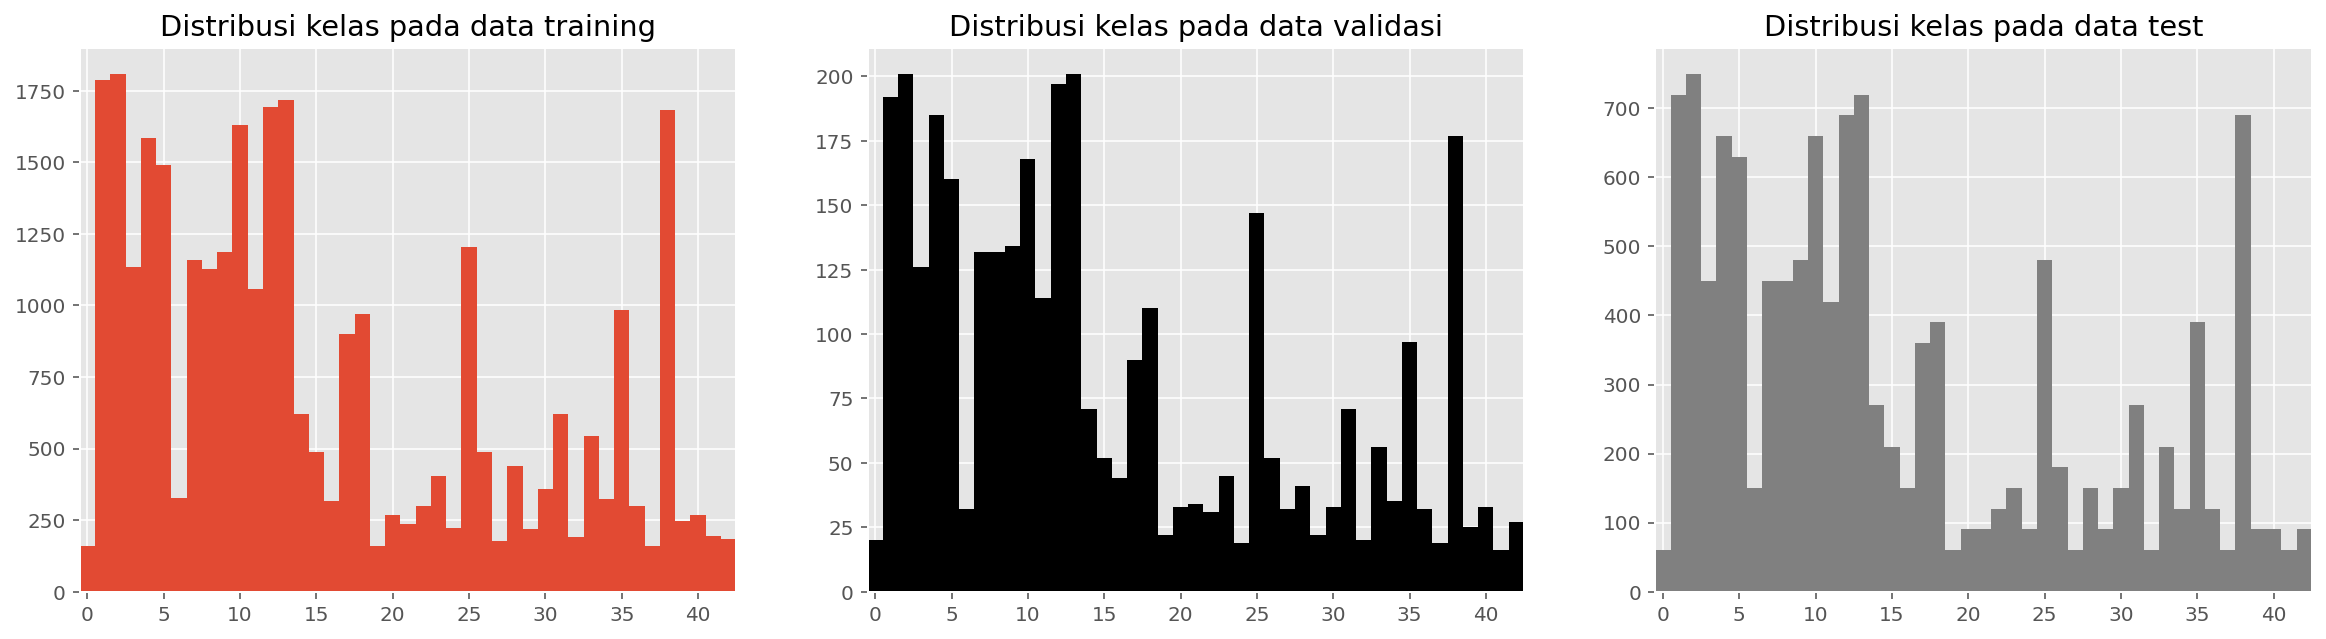

In [7]:
n_labels = np.unique(y_train).size
def hist_data(y_data, title=None, ax=None, **kwargs):
    if not ax :
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(y_data, np.arange(-0.5, n_labels+1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5, n_labels-0.5)
    if 'label' in kwargs : ax.legend()
    if title : ax.set_title(title)
        
fig,ax = plt.subplots(1,3, figsize=(20,5))
hist_data(y_train, title='Distribusi kelas pada data training', ax=ax[0])
hist_data(y_val, title='Distribusi kelas pada data validasi', ax=ax[1], color='black')
hist_data(y_test, title='Distribusi kelas pada data test', ax=ax[2], color='grey')

Dari gambar, terlihat bahwa distribusi kelas masing-masing bagian data terlihat mirip. Oleh karena itu, kita tidak perlu melakukan proses normalisasi. 



---



# Data Preparation

Tahap selanjutnya adalah Data Preparation. Pada tahap ini kita akan mengonversi label pada data training dan validasi dengan teknik one hot encoding. Tujuannya agar label, yang sebelumnya merupakan tipe data string menjadi fitur kategorik. Kita akan menggunakan fungsi [to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) dari library tensorflow.

In [8]:
# Converting the labels into one hot encoding
from tensorflow.keras.utils import to_categorical
 
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

Selanjutnya, kita akan melakukan proses training dan testing dengan teknik deep learning.



---



# Training Data

Sebelum memulai proses training, mari kita definisikan [callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback) terlebih dahulu.

Di sini kita akan langsung implementasikan callback pada model. Kita set agar training berhenti saat akurasi model mencapai 96%. Penggunaan callback akan mempersingkat waktu training sebab kita sudah definisikan di awal berapa nilai akurasi yang dibutuhkan. Sehingga, saat model telah mencapai akurasi tersebut, proses training akan berhenti.

In [9]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.96):
      print("\nAkurasi telah mencapai >96%. Stop training!")
      self.model.stop_training = True
callbacks = myCallback()

Kita akan menggunakan arsitektur C**onvolutional Neural Network** untuk proses training model.

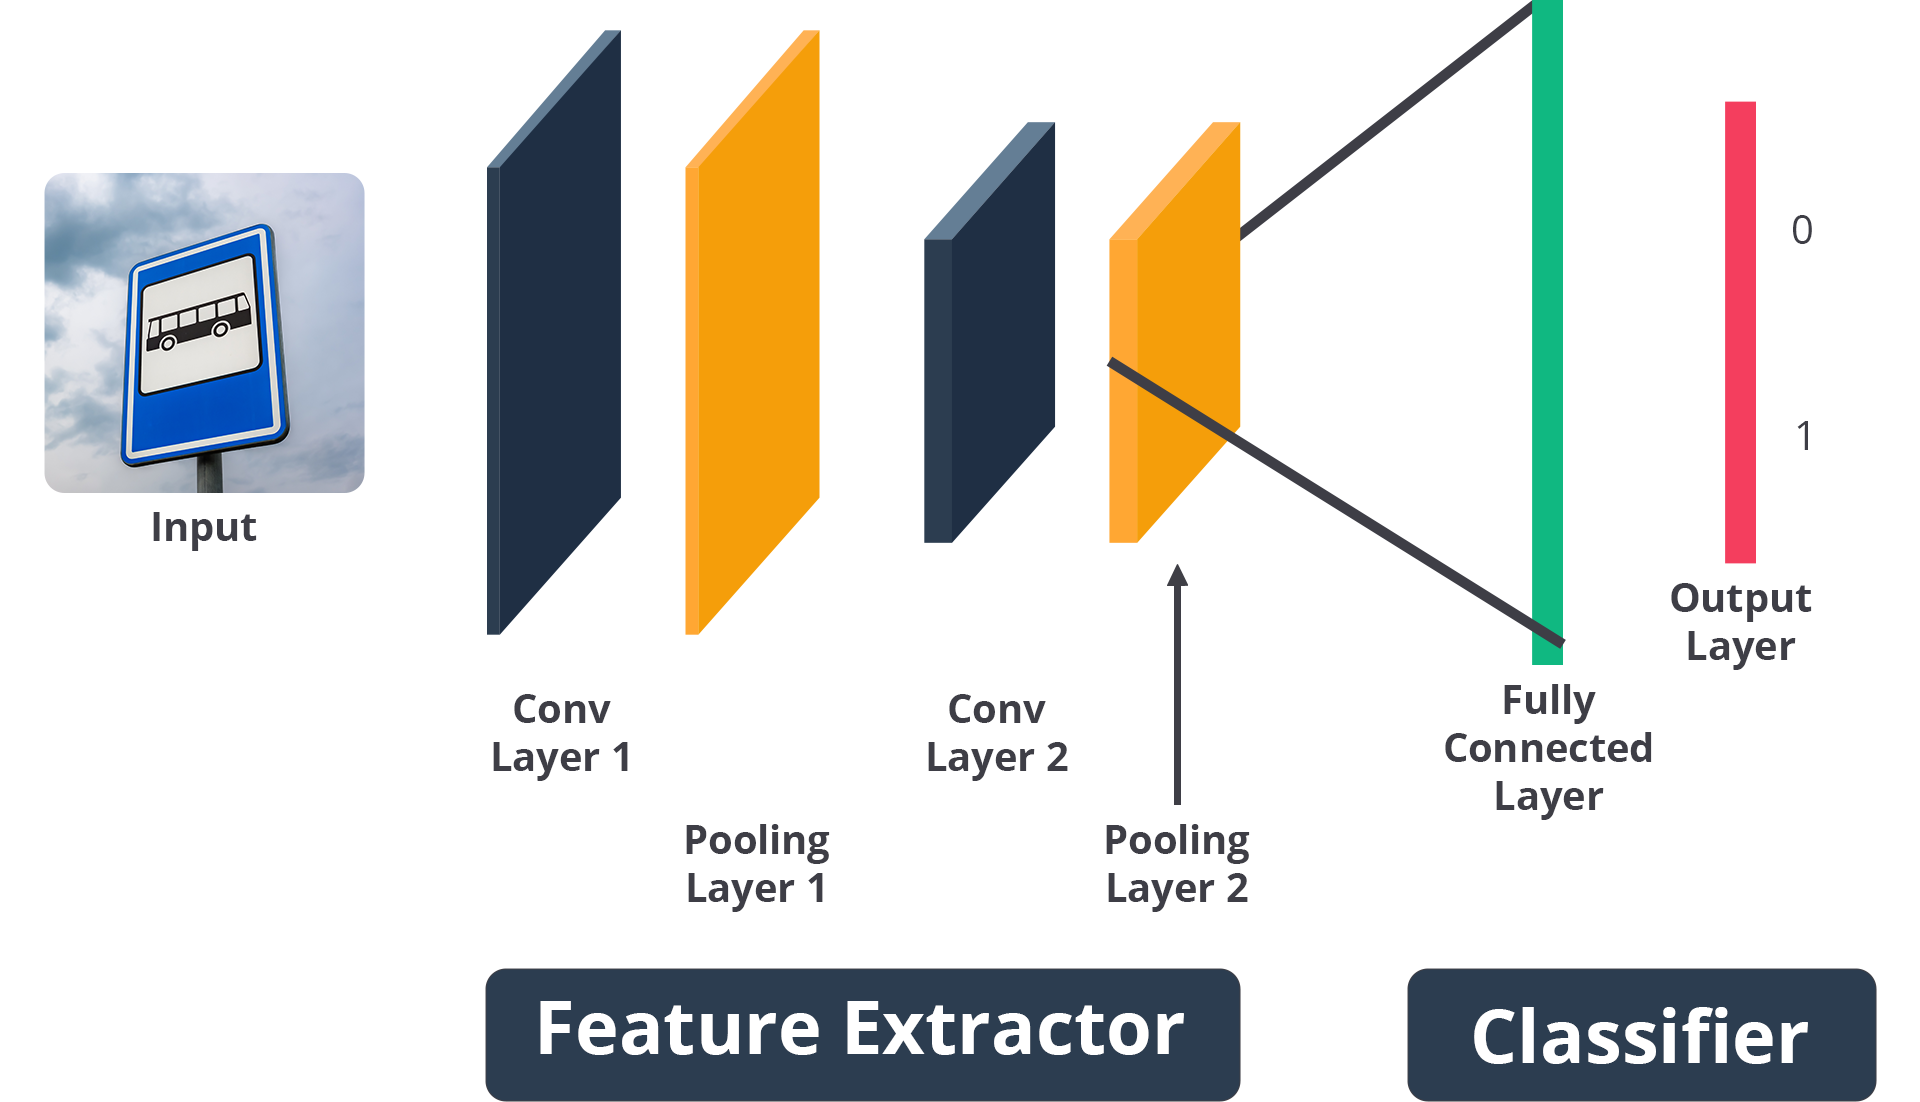

Pada proyek ini, kita menggunakan arsitektur 2 convolutional layer dan 1 fully connected layer. Untuk lebih jelasnya, mari kita bahas setiap layernya.

Pertama, inisialisasi model Sequential dan tentukan input shape untuk model. Set layer ini menggunakan kernel berukuran 5x5 untuk mempelajari fitur pada data traffic sign. Input masukan kita sesuaikan dengan shape X_train yaitu sebuah gambar RGB berukuran 32 pixels (32, 32, 3). Fungsi aktivasi yang akan kita gunakan adalah RELU, seperti yang telah dijelaskan sebelumnya. Max Pooling layer juga kita tambahkan untuk mengurangi dimensi.

Di sini, kita juga menerapkan dropout. Dropout merupakan salah satu hyperparameter yang bertujuan untuk mengurangi overfitting. Ia bekerja dengan memutus atau menjatuhkan (drop) unit selama proses training neural network sehingga layer atau lapisannya menjadi tidak aktif. Berdasarkan dokumentasi dari [Keras](https://keras.io/api/layers/regularization_layers/dropout/), argumen rate untuk dropout adalah tipe data float antara 0 dan 1, yang merupakan bagian dari unit yang akan di-drop. 

Jika kita set dropout rate = 0.25, artinya, kita akan melepas 25% dari layer dan membuatnya menjadi tidak aktif selama proses training.

Berikut set layer kita yang pertama. Pada arsitektur ini, set parameter layer sebagai berikut:
* Ukuran filter untuk proses konvolusi=32
* Ukuran kernel=(5,5)
* Fungsi aktivasi RELU
* Pooling yang kita gunakan adalah Maxpool dengan ukuran 2,2
* Dropout rate sebesar 0.25

In [10]:
# set layer pertama
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# set layer kedua
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# layer FC (Fully Connected)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0

Selanjutnya, kita akan melakukan kompilasi model dan memanggil fungsi fit untuk memulai training.

In [12]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 25
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callbacks])
model.save("my_model.h5")

Epoch 1/25
979/979 [==============================] - 10s 10ms/step - loss: 0.2791 - accuracy: 0.9233 - val_loss: 0.0967 - val_accuracy: 0.9807
Epoch 2/25
979/979 [==============================] - 9s 9ms/step - loss: 0.2574 - accuracy: 0.9275 - val_loss: 0.0579 - val_accuracy: 0.9859
Epoch 3/25
979/979 [==============================] - 9s 9ms/step - loss: 0.3161 - accuracy: 0.9161 - val_loss: 0.0634 - val_accuracy: 0.9853
Epoch 4/25
979/979 [==============================] - 9s 9ms/step - loss: 0.2688 - accuracy: 0.9234 - val_loss: 0.1184 - val_accuracy: 0.9681
Epoch 5/25
979/979 [==============================] - 9s 9ms/step - loss: 0.2438 - accuracy: 0.9293 - val_loss: 0.1220 - val_accuracy: 0.9707
Epoch 6/25
979/979 [==============================] - 9s 9ms/step - loss: 0.2568 - accuracy: 0.9259 - val_loss: 0.0846 - val_accuracy: 0.9784
Epoch 7/25
979/979 [==============================] - 9s 9ms/step - loss: 0.3241 - accuracy: 0.9112 - val_loss: 0.0847 - val_accuracy: 0.9816
Epoc

Ketahuilah, hasil training pada machine learning tidak selalu sama. Anda mungkin akan mendapat hasil akurasi tertentu yang diperoleh dengan lebih cepat atau lebih lambat. Namun, secara umum, tidak akan terlalu jauh bedanya. Jadi, tidak perlu khawatir, ya!

Perbedaan hasil ini bisa jadi disebabkan oleh perilaku dan kinerja algoritma machine learning yang bersifat stokastik. Deep neural network dilatih menggunakan algoritma optimasi penurunan gradien stokastik. Stokastik di sini mengacu pada proses yang melibatkan beberapa situasi acak (random) dan ketidakpastian (uncertainty). Sifat stokastik pada algoritma machine learning adalah konsep dasar yang penting dan harus dipahami oleh para praktisi machine learning. Tujuannya, agar kita dapat menafsirkan perilaku banyak model prediktif secara efektif. 

Terakhir, untuk mendapatkan grafik akurasi dan loss, terapkan kode berikut.

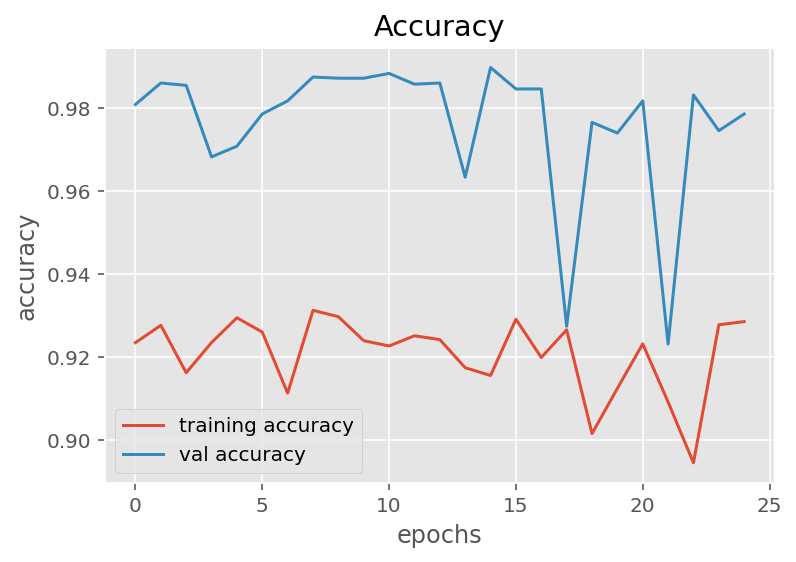

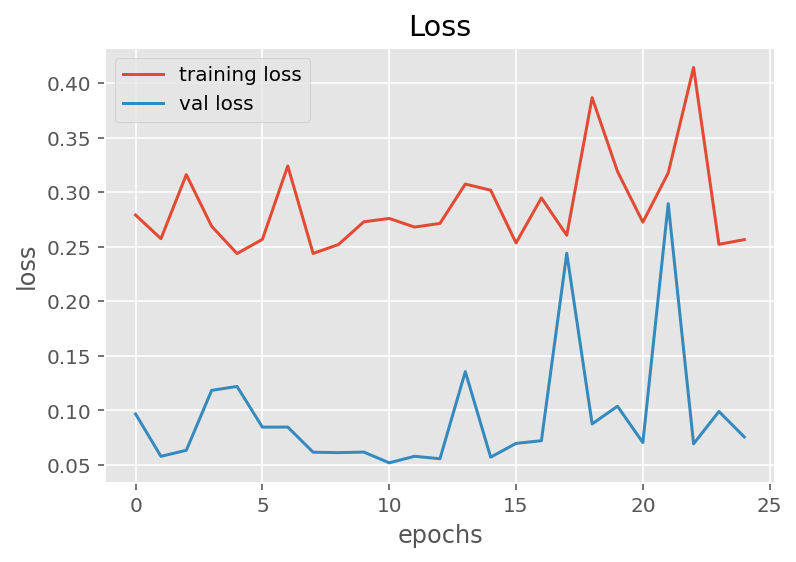

In [13]:
# Plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
 
# Plotting graphs for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()



---



# Testing Model

In [15]:
# Testing accuracy with the test data
from sklearn.metrics import accuracy_score
 
pred=np.argmax(model.predict(X_test), axis=-1)
accuracy_score(y_test, pred)

0.9150435471100554

Selanjutnya, untuk memperoleh metrik klasifikasi lain seperti precision, recall, dan f1-score, mari kita terapkan fungsi [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) dari library sklearn. 

In [16]:
# Calculate metrics for classification
from sklearn.metrics import classification_report
 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89        60
           1       0.93      0.93      0.93       720
           2       0.89      0.97      0.93       750
           3       0.95      0.91      0.93       450
           4       0.94      0.94      0.94       660
           5       0.87      0.85      0.86       630
           6       1.00      0.86      0.92       150
           7       0.96      0.88      0.92       450
           8       0.88      0.94      0.91       450
           9       0.91      0.96      0.93       480
          10       0.97      0.98      0.98       660
          11       0.92      0.88      0.90       420
          12       0.96      0.98      0.97       690
          13       0.98      0.99      0.99       720
          14       0.95      0.97      0.96       270
          15       0.96      0.99      0.97       210
          16       0.99      0.97      0.98       150
          17       1.00    